# RPGRIP1 and Associated Syndrome


Variants in [RPGRIP1](https://omim.org/entry/605446) are associated with [cone-rod dystrophy-13 (CORD13)] and
[Leber congenital amaurosis 6](https://omim.org/entry/613826). Both conditions follow an autosomal recessive
mode of inheritance.

Data in this cohort are dervied from [Beryozkin A, et al. (2021) Retinal Degeneration Associated With RPGRIP1: A Review of Natural History, Mutation Spectrum, and Genotype-Phenotype Correlation in 228 Patients. Front Cell Dev Biol](https://pubmed.ncbi.nlm.nih.gov/34722527/)


<!-- Summarize key findings from previous studies on genotype-phenotype correlations in the syndrome. -->

One/Two/Several previous publications have reported candidate genotype-phenotype correlations in [Syndrome Name].

<!-- Cite specific studies and their findings. Replace with relevant studies and findings for the specific gene and syndrome. -->

[Author et al. (Year)](link_to_study) stated that:

> [Quote relevant finding from the study]

[Author et al. (Year)](link_to_study) stated that:

> [Quote relevant finding from the study]

[Author et al. (Year)](link_to_study) report:

> [Quote relevant finding from the study]

<!-- TODO: Add instructions for finding more comprehensive citations and explain the next steps in your analysis. -->

TODO -- find a more comprehensive collection of citations for [GeneName]. At the end of the introduction for a gene, we would write something like this:

> Example: Therefore, we tested missense vs other variants (inspection of the distribution of variants showed that the other variant categories in our dataset are [list other variant categories], all of which we deemed to be null variants for the purposes of this analysis). We also tested the two most common missense variants ([DETAILS]) for correlations.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}.')
print(f"Using gpsea version {gpsea.__version__}.")

Loaded HPO v2024-08-13.
Using gpsea version 0.7.0.


## RPGRIP1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for RPGRIP1.

In [3]:
gene_symbol = 'RPGRIP1'
mane_tx_id = 'NM_020366.4'
mane_protein_id = 'NP_065099.3' # X-linked retinitis pigmentosa GTPase regulator-interacting protein 1 isoform 1

In [2]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
cohort_name = "RPGRIP1"
#with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
#    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))
#print(f"Imported {len(phenopackets)} phenopackets from cohort {cohort_name}")

from pyphetools.visualization import PhenopacketIngestor
rpgrip1_dir = "/Users/robin/GIT/phenopacket-store/notebooks/RPGRIP1/phenopackets"
ingestor = PhenopacketIngestor(indir=rpgrip1_dir)
ppkt_list = ingestor.get_phenopacket_list()
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=ppkt_list, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

[pyphetools] Ingested 100 GA4GH phenopackets.
Individuals Processed: 100%|██████████| 100/100 [00:20<00:00,  4.94individuals/s]
Loaded 100 individuals
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #1
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #2
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #3
    phenotype-features
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #4
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #6
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #8
  

In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Nystagmus,HP:0000639,75
Abnormal electroretinogram,HP:0000512,49
Reduced visual acuity,HP:0007663,43
Hypermetropia,HP:0000540,40
Very low visual acuity,HP:0032122,39
Eye poking,HP:0001483,35
Retinal pigment epithelial mottling,HP:0007814,33
Attenuation of retinal blood vessels,HP:0007843,30
Retinal degeneration,HP:0000546,19
Photophobia,HP:0000613,17


In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_54275/1613228306.py:4: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


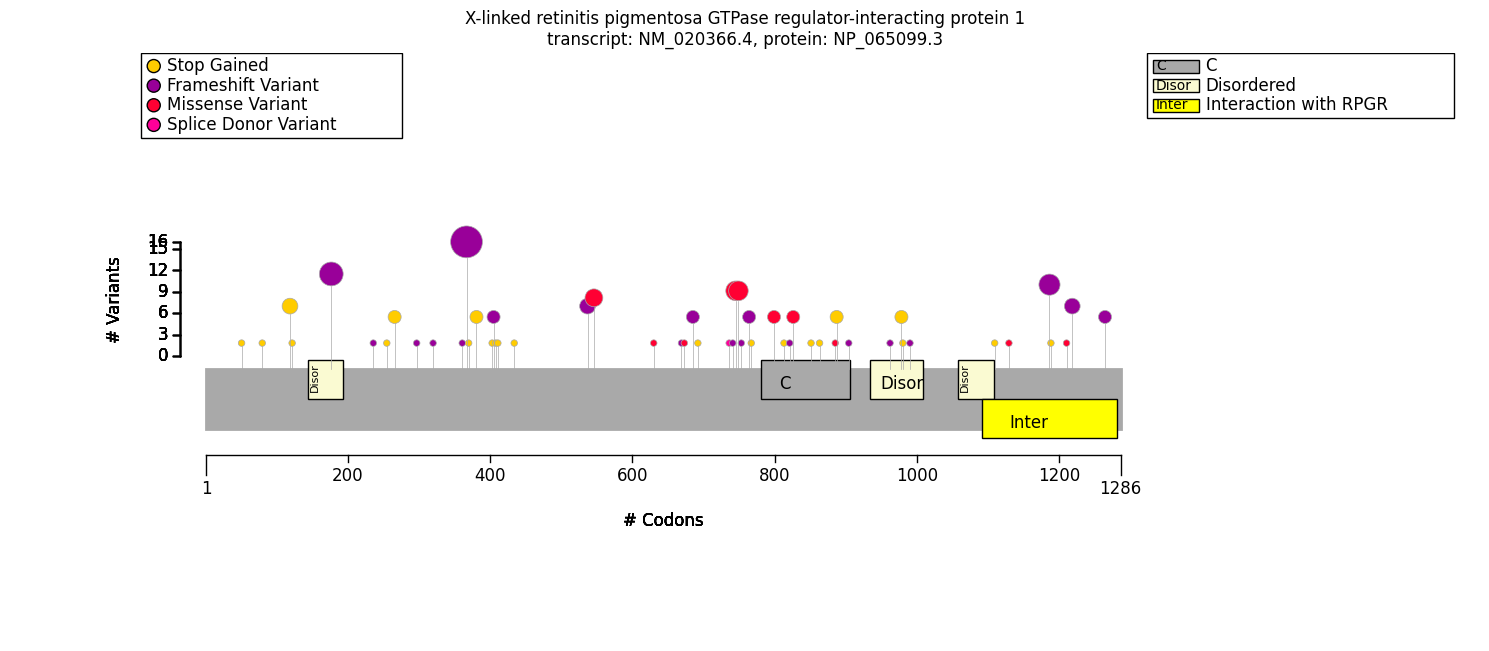

In [6]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [12]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter( hpo=hpo, annotation_frequency_threshold=0.01)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
     mtc_alpha=mtc_alpha,
)

In [13]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates,VariantPredicate

vp = VariantPredicates.variant_key("14_21312457_21312458_GA_G")  #	c.1107del	p.Glu370AsnfsTer5	

from gpsea.analysis.predicate.genotype import biallelic_predicate
gt_predicate = biallelic_predicate(
    a_predicate=vp,
    b_predicate=~vp,
    a_label="1107del",
    b_label="other",
    partitions = ({0,}, {1, 2})
)
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)


Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,13
HMF03,Skipping term because of a child term with the same individual counts,3
HMF05,Skipping term because one genotype had zero observations,18
HMF06,Skipping term with less than 7 observations (not powered for 2x2),32
HMF08,Skipping general term,24


In [14]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       1107del/1107del          \
                                                             Count Percent   
Eye poking [HP:0001483]                                      16/16    100%   
Very low visual acuity [HP:0032122]                          11/11    100%   
Photophobia [HP:0000613]                                       0/5      0%   
Hypermetropia [HP:0000540]                                   16/16    100%   
Retinal pigment epithelial mottling [HP:0007814]             11/13     85%   
Attenuation of retinal blood vessels [HP:0007843]              5/5    100%   
Nystagmus [HP:0000639]                                       11/11    100%   
Abnormal involuntary eye movements [HP:0012547]              11/11    100%   
Tactile sensory seeking [HP:5200065]                         16/16    100%   
Sensory behavioral abnormality [HP:5200046]                  16/16    100%   
Atypical behavior [HP:0000708]                               16/16    100%   
Steroetypic movements of face and head [HP:5200...           16/16    100%   
Recurrent maladaptive behavior [HP:5200241]                  16/16    100%   
Self-injurious behavior [HP:0100716]                         16/16    100%   
Abnormality of retinal pigmentation [HP:0007703]             13/13    100%   
Abnormal retinal morphology [HP:0000479]                     14/14    100%   
Abnormal fundus morphology [HP:0001098]                      14/14    100%   
Reduced visual acuity [HP:0007663]                           16/16    100%   
Visual impairment [HP:0000505]                               16/16    100%   
Abnormal electroretinogram [HP:0000512]                        5/5    100%   
Abnormal retinal vascular morphology [HP:0008046]              5/5    100%   
Bone spicule pigmentation of the retina [HP:000...             2/4     50%   
Pigmentary retinopathy [HP:0000580]                            2/2    100%   

Allele group                                       1107del/other OR other/other  \
                                                                          Count   
Eye poking [HP:0001483]                                                   19/41   
Very low visual acuity [HP:0032122]                                       28/44   
Photophobia [HP:0000613]                                                  17/37   
Hypermetropia [HP:0000540]                                                24/27   
Retinal pigment epithelial mottling [HP:0007814]                          22/33   
Attenuation of retinal blood vessels [HP:0007843]                         25/37   
Nystagmus [HP:0000639]                                                    64/71   
Abnormal involuntary eye movements [HP:0012547]                           64/64   
Tactile sensory seeking [HP:5200065]                                      19/19   
Sensory behavioral abnormality [HP:5200046]                               35/35   
Atypical behavior [HP:0000708]                                            35/35   
Steroetypic movements of face and head [HP:5200...                        19/19   
Recurrent maladaptive behavior [HP:5200241]                               19/19   
Self-injurious behavior [HP:0100716]                                      19/19   
Abnormality of retinal pigmentation [HP:0007703]                          30/30   
Abnormal retinal morphology [HP:0000479]                                  66/66   
Abnormal fundus morphology [HP:0001098]                                   67/67   
Reduced visual acuity [HP:0007663]                                        82/82   
Visual impairment [HP:0000505]                                            82/82   
Abnormal electroretinogram [HP:0000512]                                   44/44   
Abnormal retinal vascular morphology [HP:0008046]                         26/26   
Bone spicule pigmentation of the retina [HP:000...                        12/31   
Pigmentary retinopathy [HP:0000580]                      

In [17]:
is_frameshift = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)

gt_predicate = biallelic_predicate(
    a_predicate=is_frameshift,
    b_predicate=~is_frameshift,
    a_label="frameshift",
    b_label="other",
    partitions = ({0,}, {1, 2})
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)


summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       frameshift/frameshift  \
                                                                   Count   
Eye poking [HP:0001483]                                            22/29   
Posterior subcapsular cataract [HP:0007787]                         5/11   
Photophobia [HP:0000613]                                            4/17   
Optic disc pallor [HP:0000543]                                      6/11   
Bone spicule pigmentation of the retina [HP:000...                  7/13   
Color vision defect [HP:0000551]                                     0/1   
Nyctalopia [HP:0000662]                                              5/5   
Hypermetropia [HP:0000540]                                         23/24   
Subcapsular cataract [HP:0000523]                                    5/8   
Moderately reduced visual acuity [HP:0030515]                        5/7   
Cataract [HP:0000518]                                                5/8   
Very low visual acuity [HP:0032122]                                18/24   
Nystagmus [HP:0000639]                                             28/30   
Abnormal involuntary eye movements [HP:0012547]                    28/28   
Tactile sensory seeking [HP:5200065]                               22/22   
Sensory behavioral abnormality [HP:5200046]                        26/26   
Atypical behavior [HP:0000708]                                     26/26   
Steroetypic movements of face and head [HP:5200...                 22/22   
Recurrent maladaptive behavior [HP:5200241]                        22/22   
Self-injurious behavior [HP:0100716]                               22/22   
Retinal pigment epithelial mottling [HP:0007814]                   16/22   
Abnormality of retinal pigmentation [HP:0007703]                   22/22   
Abnormal retinal morphology [HP:0000479]                           32/32   
Abnormal fundus morphology [HP:0001098]                            32/32   
Abnormal optic disc morphology [HP:0012795]                          6/6   
Reduced visual acuity [HP:0007663]                                 37/37   
Visual impairment [HP:0000505]                                     37/37   
Abnormal electroretinogram [HP:0000512]                            19/19   
Attenuation of retinal blood vessels [HP:0007843]                  13/18   
Abnormal retinal vascular morphology [HP:0008046]                  13/13   
Retinal degeneration [HP:0000546]                                  10/10   
Absent foveal reflex [HP:0030825]                                    1/1   
Abnormal macular morphology [HP:0001103]                             7/7   
Pigmentary retinopathy [HP:0000580]                                  7/7   
Sensory hypersensitivity [HP:5200058]                                4/4   
Retinal atrophy [HP:0001105]                                         6/6   
Macular degeneration [HP:0000608]                                    5/5   
Abnormal lens morphology [HP:0000517]                                5/5   
Constriction of peripheral visual field [HP:000...                   5/5   

Allele group                                                \
                                                   Percent   
Eye poking [HP:0001483]                                76%   
Posterior subcapsular cataract [HP:0007787]            45%   
Photophobia [HP:0000613]                               24%   
Optic disc pallor [HP:0000543]                         55%   
Bone spicule pigmentation of the retina [HP:000...     54%   
Color vision defect [HP:0000551]                        0%   
Nyctalopia [HP:0000662]                               100%   
Hypermetropia [HP:0000540]                             96%   
Subcapsular cataract [HP:0000523]                      62%   
Moderately reduced visual acuity [HP:0030515]          71%   
Cataract [HP:0000518]                                  62%   
Very low visual acuity [HP:0032122]                    75%   
Nystagmus [HP:0

In [18]:
is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

gt_predicate = biallelic_predicate(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="missense",
    b_label="other",
    partitions = ({0,}, {1, 2})
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       missense/missense          \
                                                               Count Percent   
Color vision defect [HP:0000551]                                 5/5    100%   
Optic disc pallor [HP:0000543]                                   0/6      0%   
Nystagmus [HP:0000639]                                          9/12     75%   
Macular atrophy [HP:0007401]                                     3/5     60%   
Photophobia [HP:0000613]                                        8/14     57%   
Bone spicule pigmentation of the retina [HP:000...               5/8     62%   
Retinal degeneration [HP:0000546]                               9/10     90%   
Retinal atrophy [HP:0001105]                                     3/4     75%   
Nyctalopia [HP:0000662]                                          1/2     50%   
Retinal pigment epithelial mottling [HP:0007814]                 5/5    100%   
Eye poking [HP:0001483]                                          3/7     43%   
Very low visual acuity [HP:0032122]                              5/9     56%   
Subcapsular cataract [HP:0000523]                                2/2    100%   
Cataract [HP:0000518]                                            2/2    100%   
Posterior subcapsular cataract [HP:0007787]                      2/5     40%   
Abnormal involuntary eye movements [HP:0012547]                  9/9    100%   
Tactile sensory seeking [HP:5200065]                             3/3    100%   
Sensory behavioral abnormality [HP:5200046]                    11/11    100%   
Atypical behavior [HP:0000708]                                 11/11    100%   
Steroetypic movements of face and head [HP:5200...               3/3    100%   
Recurrent maladaptive behavior [HP:5200241]                      3/3    100%   
Self-injurious behavior [HP:0100716]                             3/3    100%   
Abnormality of retinal pigmentation [HP:0007703]                 8/8    100%   
Abnormal retinal morphology [HP:0000479]                       17/17    100%   
Abnormal fundus morphology [HP:0001098]                        17/17    100%   
Reduced visual acuity [HP:0007663]                             18/18    100%   
Visual impairment [HP:0000505]                                 18/18    100%   
Abnormal electroretinogram [HP:0000512]                        10/10    100%   
Hypermetropia [HP:0000540]                                       6/6    100%   
Attenuation of retinal blood vessels [HP:0007843]               7/10     70%   
Abnormal retinal vascular morphology [HP:0008046]                7/7    100%   
Absent foveal reflex [HP:0030825]                                1/1    100%   
Abnormal macular morphology [HP:0001103]                         9/9    100%   
Pigmentary retinopathy [HP:0000580]                              5/5    100%   
Sensory hypersensitivity [HP:5200058]                            8/8    100%   
Macular degeneration [HP:0000608]                                8/9     89%   
Moderately reduced visual acuity [HP:0030515]                    4/7     57%   
Abnormal lens morphology [HP:0000517]                            2/2    100%   
Progressive visual loss [HP:0000529]                             5/5    100%   
Constriction of peripheral visual field [HP:000...               2/2    100%   

Allele group                                       missense/other OR other/other  \
                                                                           Count   
Color vision defect [HP:0000551]                                             2/8   
Optic disc pallor [HP:0000543]                                              9/18   
Nystagmus [HP:0000639]                                                     66/70   
Macular atrophy [HP:0007401]                                                9/35   
Photophobia [HP:0000613]                                                    9/28   
Bone spicule pigmentation of the retina [HP:000... 

In [19]:
from gpsea.analysis.predicate.genotype import sex_predicate
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Bone spicule pigmentation of the retina [HP:000...   8/15     53%   6/20   
Attenuation of retinal blood vessels [HP:0007843]   14/17     82%  15/24   
Very low visual acuity [HP:0032122]                 20/25     80%  19/29   
Nystagmus [HP:0000639]                              36/38     95%  36/41   
Hypermetropia [HP:0000540]                          23/25     92%  17/17   
Moderately reduced visual acuity [HP:0030515]         3/4     75%   6/11   
Optic disc pallor [HP:0000543]                        4/9     44%   4/14   
Retinal pigment epithelial mottling [HP:0007814]    20/27     74%  12/18   
Eye poking [HP:0001483]                             20/31     65%  15/25   
Abnormal involuntary eye movements [HP:0012547]     36/36    100%  36/36   
Tactile sensory seeking [HP:5200065]                20/20    100%  15/15   
Sensory behavioral abnormality [HP:5200046]         25/25    100%  22/22   
Atypical behavior [HP:0000708]                      25/25    100%  22/22   
Steroetypic movements of face and head [HP:5200...  20/20    100%  15/15   
Recurrent maladaptive behavior [HP:5200241]         20/20    100%  15/15   
Self-injurious behavior [HP:0100716]                20/20    100%  15/15   
Abnormality of retinal pigmentation [HP:0007703]    24/24    100%  18/18   
Abnormal retinal morphology [HP:0000479]            37/37    100%  38/38   
Abnormal fundus morphology [HP:0001098]             37/37    100%  39/39   
Abnormal optic disc morphology [HP:0012795]           4/4    100%    5/5   
Reduced visual acuity [HP:0007663]                  44/44    100%  49/49   
Visual impairment [HP:0000505]                      44/44    100%  49/49   
Abnormal electroretinogram [HP:0000512]             21/21    100%  22/22   
Abnormal retinal vascular morphology [HP:0008046]   15/15    100%  15/15   
Retinal degeneration [HP:0000546]                   16/16    100%  18/19   
Absent foveal reflex [HP:0030825]                     2/3     67%    2/5   
Abnormal macular morphology [HP:0001103]            10/10    100%    9/9   
Pigmentary retinopathy [HP:0000580]                   8/8    100%    6/6   
Sensory hypersensitivity [HP:5200058]                 6/6    100%    7/7   
Retinal atrophy [HP:0001105]                          7/7    100%    6/7   
Macular degeneration [HP:0000608]                     7/7    100%    7/8   
Subcapsular cataract [HP:0000523]                     4/7     57%    4/9   
Cataract [HP:0000518]                                 4/7     57%   5/10   
Abnormal lens morphology [HP:0000517]                 4/4    100%    5/5   
Nyctalopia [HP:0000662]                               3/3    100%    8/9   
Color vision defect [HP:0000551]                      2/5     40%    2/5   
Constriction of peripheral visual field [HP:000...    4/4    100%    7/7   

Sex                                                                            \
                                                   Percent Corrected p values   
Bone spicule pigmentation of the retina [HP:000...     30%                1.0   
Attenuation of retinal blood vessels [HP:0007843]      62%                1.0   
Very low visual acuity [HP:0032122]                    66%                1.0   
Nystagmus [HP:0000639]                                 88%                1.0   
Hypermetropia [HP:0000540]                            100%                1.0   
Moderately reduced visual acuity [HP:0030515]          55%                1.0   
Optic disc pallor [HP:0000543]                         29%                1.0   
Retinal pigment epithelial mottling [HP:0007814]       67%                1.0   
Eye poking [HP:0001483]                                60%                1.0   
Abnormal involuntary eye movements [HP:0012547]       100%                1.0   
Tactile sensory seeking [HP:5200065]                  100%     